-sandbox

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>

# Lab: Diving into the Transformer - Utilizing embeddings from transformers

In this lab, we will delve into the workings of the Transformer's encoder. We will build the components needed to create our encoder-based model and investigate the embeddings it produces. You will then be asked questions related to these embeddings, including comparisons, distance measurements, and the utilization of masked language modeling (MLM).

### ![Dolly](https://files.training.databricks.com/images/llm/dolly_small.png) Learning Objectives
1. Develop an encoder from scratch
2. Investigating word embeddings (from our untrained models, and BERT)
4. Gain practice in Masked Language Modeling (MLM)

## Classroom Setup

In [0]:
%run ../Includes/Classroom-Setup

/databricks/python/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


Resetting the learning environment:
| enumerating serving endpoints...found 0...(0 seconds)
| No action taken

Skipping install of existing datasets to "dbfs:/mnt/dbacademy-datasets/llm-foundation-models/v01-raw"

Validating the locally installed datasets:
| listing local files...(4 seconds)
| validation completed...(4 seconds total)


Importing lab testing framework.



Using the "default" schema.

Predefined paths variables:
| DA.paths.working_dir: /dbfs/mnt/dbacademy-users/labuser4573502@vocareum.com/llm-foundation-models
| DA.paths.user_db:     dbfs:/mnt/dbacademy-users/labuser4573502@vocareum.com/llm-foundation-models/database.db
| DA.paths.datasets:    /dbfs/mnt/dbacademy-datasets/llm-foundation-models/v01-raw

Setup completed (7 seconds)

The models developed or used in this course are for demonstration and learning purposes only.
Models may occasionally output offensive, inaccurate, biased information, or harmful instructions.


In [0]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Section 1 - Building our own Encoder Transformer

### Define the Feed Forward Network

We begin by defining the FeedForward class, which represents a simple feed-forward neural network with two linear layers separated by a ReLU activation function, and a dropout layer for regularization.

In [0]:
class FeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim, dropout = 0.1):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


### Define the Transformer Encoder Block

The TransformerEncoderBlock class represents a single block of the transformer encoder, which consists of a multi-head self-attention layer and a feed-forward neural network, with layer normalization and residual connections applied to the outputs of each layer.

In [0]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, conv_hidden_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Multi-Head Attention
        attn_output, _ = self.attention(x, x, x, attn_mask=mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)

        # Feed Forward Network
        ff_output = self.feed_forward(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)

        return x


### Define the Transformer Encoder

The TransformerEncoder class represents the complete transformer encoder, which consists of a word embedding layer, a positional encoding layer, and a series of transformer encoder blocks.

In [0]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, conv_hidden_dim, num_layers, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(1000, d_model)  # Assuming a maximum sequence length of 1000
        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(d_model, num_heads, conv_hidden_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x, mask=None):
        seq_length = x.shape[1]
        positions = torch.arange(0, seq_length).expand(x.shape[0], seq_length).to(x.device)
        out = self.word_embedding(x) + self.position_embedding(positions)

        for layer in self.layers:
            out = layer(out, mask)

        return out


### Instantiate the Model and Perform a Forward Pass

We now instantiate the model with a specific set of hyperparameters, generate some random input data, and perform a forward pass through the model.

In [0]:
# Assume the following hyperparameters
vocab_size = 5000  # size of the vocabulary
d_model = 512  # dimension of the word embedding
num_heads = 8  # number of attention heads
conv_hidden_dim = 2048  # dimension of the hidden layer in the feed-forward network
num_layers = 6  # number of Transformer Encoder blocks
dropout = 0.1  # dropout rate

# Instantiate the model
model = TransformerEncoder(vocab_size, d_model, num_heads, conv_hidden_dim, num_layers, dropout)

# Generate some example input
input_tensor = torch.randint(0, vocab_size, (1, 20))  # batch size of 1 and sequence length of 20

# Forward pass through the model
output = model(input_tensor, mask=None)



print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

The model has 21,986,304 trainable parameters


### Investigate Word Embeddings

We now generate some random input data and perform a forward pass through the model to obtain the embeddings for each word in the input.

In [0]:
# Generate some example input
input_tensor = torch.randint(0, vocab_size, (1, 5))  # batch size of 1 and sequence length of 5

# Forward pass through the model
embeddings = model(input_tensor, mask=None)

# The `embeddings` tensor now contains the contextualized embeddings for each word in the input sequence
print(embeddings)


tensor([[[-6.3370e-01,  7.2657e-02, -1.4153e+00,  ..., -8.4549e-01,
           1.4933e+00,  4.2934e-01],
         [ 1.4751e+00, -8.0095e-01, -7.1945e-01,  ..., -9.8679e-01,
           1.8437e-01, -1.0264e+00],
         [ 1.2082e+00, -5.6453e-01, -1.8359e+00,  ...,  1.4615e+00,
          -2.0611e+00,  4.6278e-01],
         [-1.2186e+00, -8.5187e-02, -2.6919e+00,  ..., -4.5768e-01,
           4.9278e-01,  8.5357e-01],
         [ 8.0240e-01, -1.8043e+00,  1.0521e-03,  ...,  1.3950e+00,
          -9.0209e-01, -2.8842e-01]]], grad_fn=<NativeLayerNormBackward0>)


### Define Vocabulary and Word-to-ID Mapping

To interpret the input and output of our model, we define a vocabulary and a mapping from words to their corresponding IDs.

In [0]:
# Let's assume the following is our vocabulary
vocabulary = [
    "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", 
    "the", "a", "an", 
    "cat", "dog", "fish", "bird", "lion", "tiger", "elephant", "monkey",
    "runs", "jumps", "sleeps", "eats", "drinks",
    "fast", "slow", "big", "small", "red", "green", "blue", "yellow",
    "is", "was", "will", "can", "has", "have", "had", "do", "does",
    "I", "you", "he", "she", "it", "we", "they",
    "my", "your", "his", "her", "its", "our", "their"
]

# Create a word2id dictionary
word2id = {word: idx for idx, word in enumerate(vocabulary)}

# Print the dictionary
print(word2id)


{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, 'the': 5, 'a': 6, 'an': 7, 'cat': 8, 'dog': 9, 'fish': 10, 'bird': 11, 'lion': 12, 'tiger': 13, 'elephant': 14, 'monkey': 15, 'runs': 16, 'jumps': 17, 'sleeps': 18, 'eats': 19, 'drinks': 20, 'fast': 21, 'slow': 22, 'big': 23, 'small': 24, 'red': 25, 'green': 26, 'blue': 27, 'yellow': 28, 'is': 29, 'was': 30, 'will': 31, 'can': 32, 'has': 33, 'have': 34, 'had': 35, 'do': 36, 'does': 37, 'I': 38, 'you': 39, 'he': 40, 'she': 41, 'it': 42, 'we': 43, 'they': 44, 'my': 45, 'your': 46, 'his': 47, 'her': 48, 'its': 49, 'our': 50, 'their': 51}


### Measure Sentence Similarity

We define a function to measure the cosine similarity between two sentences, which is done by averaging the embeddings of the words in each sentence and then calculating the cosine similarity between these average embeddings.

In [0]:
# Define a simple function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    vec1 = vec1.squeeze()  # remove dimensions of size 1
    vec2 = vec2.squeeze()  # remove dimensions of size 1
    return torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))

# Define a function to convert a sentence into embeddings
def sentence_to_embeddings(sentence, model, word2id):
    # Convert sentence to token ids
    input_tensor = torch.tensor([word2id.get(word, word2id["[UNK]"]) for word in sentence.split()], dtype=torch.long).unsqueeze(0)
    embeddings = model(input_tensor, mask=None)
    return embeddings

# Define a function to compute the similarity between two sentences
def sentence_similarity(sentence1, sentence2, model, word2id):
    embeddings1 = sentence_to_embeddings(sentence1, model, word2id)
    embeddings2 = sentence_to_embeddings(sentence2, model, word2id)

    # Compute the average embeddings of each sentence
    avg_embedding1 = torch.mean(embeddings1, dim=1)
    avg_embedding2 = torch.mean(embeddings2, dim=1)

    # Compute and return the cosine similarity
    return cosine_similarity(avg_embedding1, avg_embedding2)

# Now we can compute the similarity between two sentences
sentence1 = "the cat has a blue fish"
sentence2 = "my sister's dog sleeps"
# Compute the similarity
similarity = sentence_similarity(sentence1, sentence2, model, word2id)

# Extract the value from the tensor and convert it to a Python float
similarity_score = similarity.item()

# Print the result with a descriptive sentence
print(f"The cosine similarity between the sentences '{sentence1}' and '{sentence2}' is {similarity_score:.2f}.")

The cosine similarity between the sentences 'the cat has a blue fish' and 'my sister's dog sleeps' is 0.47.


### Visualize Word Embeddings

We define a function to visualize the embeddings of a set of words in 2D space, which is done by using PCA to reduce the dimensionality of the embeddings to 2 and then plotting them.

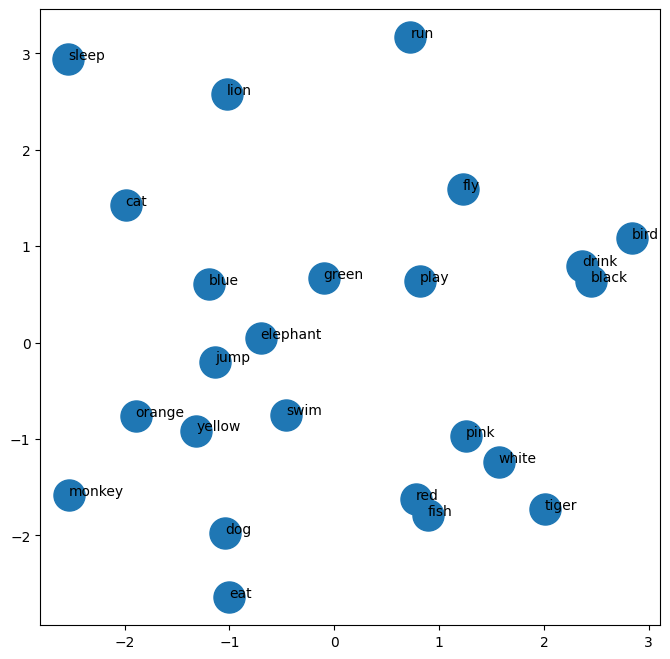

In [0]:
# Import necessary libraries
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define a list of words to plot
words = [
    # Animals
    "cat", "dog", "fish", "bird", "lion", "tiger", "elephant", "monkey",
    # Colors
    "red", "green", "blue", "yellow", "black", "white", "pink", "orange",
    # Verbs
    "run", "jump", "swim", "fly", "eat", "drink", "sleep", "play"
]
# Create artificial embeddings for demonstration purposes
embeddings = np.array([np.random.rand(512) for _ in words])  # 512 is the dimension of the embeddings

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()



### Compare with Pre-Trained BERT Embeddings

We load a pre-trained BERT model, generate embeddings for a set of words, and visualize them in the same way as before.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


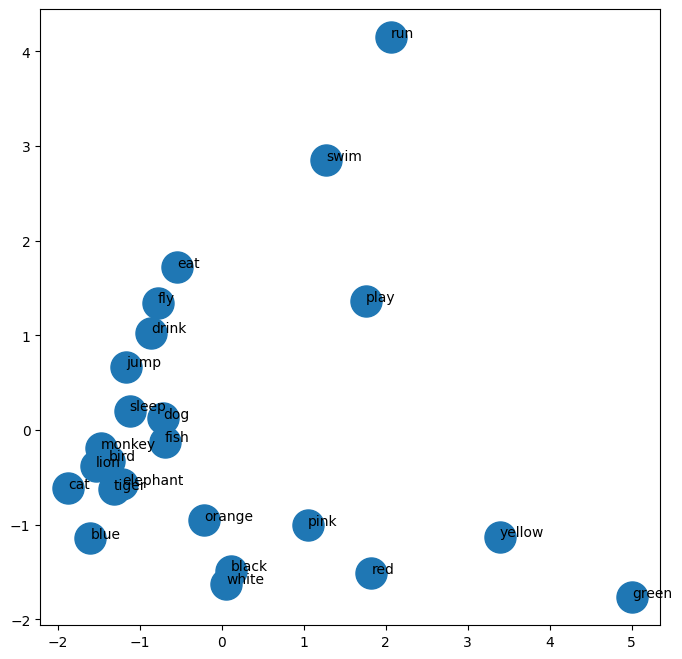

In [0]:
# Import necessary libraries
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
model_bert = BertModel.from_pretrained(model_name, cache_dir=DA.paths.datasets+"/models")
tokenizer = BertTokenizer.from_pretrained(model_name, cache_dir=DA.paths.datasets+"/models")

# Define a list of words to plot
words = [
    # Animals
    "cat", "dog", "fish", "bird", "lion", "tiger", "elephant", "monkey",
    # Colors
    "red", "green", "blue", "yellow", "black", "white", "pink", "orange",
    # Verbs
    "run", "jump", "swim", "fly", "eat", "drink", "sleep", "play"
]
# Get the embeddings of the words
embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        outputs = model_bert(**inputs)
    embeddings.append(outputs.last_hidden_state[0, 0, :].numpy())

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

# Section 1 - Questions

Having built our transformer encoder and inspected the embeddings it produces, we can now explore some questions related to these embeddings.

**Question 1:** 
How does changing different hyperparameters (e.g., the dimension of the word embeddings, the number of attention heads, the dimension of the hidden layer in the feed-forward network, the number of encoder blocks, and the dropout rate) affect the overall size of the model?

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
# TODO
# Use different parameters to see the effects on the overall model size. 
# Assume the following hyperparameters
vocab_size = 5000  # size of the vocabulary
d_model = 1024  # dimension of the word embedding
num_heads = 8  # number of attention heads
conv_hidden_dim = 2048  # dimension of the hidden layer in the feed-forward network
num_layers = 6  # number of Transformer Encoder blocks
dropout = 0.1  # dropout rate
# Create a Transformer Encoder with different hyperparameters
new_model = TransformerEncoder(vocab_size , d_model , num_heads , conv_hidden_dim , num_layers , dropout)
print(f"The model has {count_parameters(new_model):,} trainable parameters, compared to the 21,986,304 of the original model")

The model has 56,543,232 trainable parameters, compared to the 21,986,304 of the original model


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_1(new_model)

PASSED: All tests passed for lesson1, question1
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 2:** 
Visualize the embeddings of a different set of words. Try choosing a set of words that are related in some way, such as words related to a particular topic or words that are all of a certain type (e.g., all verbs or all nouns).

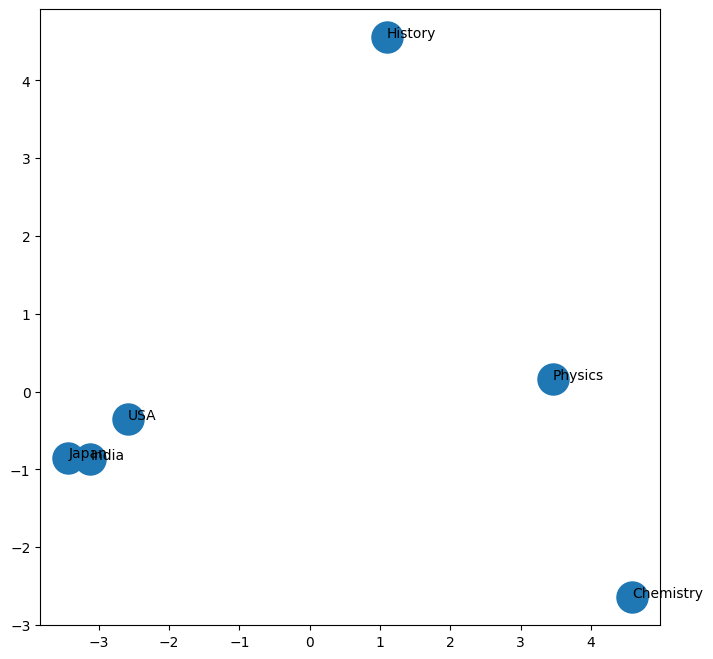

In [0]:
# TODO
words = ["India","USA","Japan","History","Physics","Chemistry"]

# Get the embeddings of the words
embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        outputs = model_bert(**inputs)
    embeddings.append(outputs.last_hidden_state[0, 0, :].numpy())

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_2(words)

PASSED: All tests passed for lesson1, question2
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 3:** 
Compute the cosine similarity between the embeddings of a sentence and its scrambled version. For example, compare the sentence "the cat chased the dog" with "dog the chased cat the". What do you observe?

In [0]:

# Get the embeddings of the words
def get_bert_embeddings(word):
  embeddings = []
  for word in words:
      inputs = tokenizer(word, return_tensors='pt')
      with torch.no_grad():
          outputs = model_bert(**inputs)
      embeddings.append(outputs.last_hidden_state[0, 0, :].numpy())
  return embeddings

      


# TODO
# Define a sentence and its scrambled version
sentence_q3 = "the cat chased the dog"
scrambled_sentence_q3 = "dog the chased cat the"

# Compute embeddings and cosine similarity
original_embedding = get_bert_embeddings(sentence_q3)
scrambled_embedding = get_bert_embeddings(scrambled_sentence_q3)

# Compute the average embeddings of each sentence
avg_embedding_original = torch.mean(torch.tensor(original_embedding),dim=0)
avg_embedding_scrambled = torch.mean(torch.tensor(scrambled_embedding),dim=0)

similarity = cosine_similarity(avg_embedding_original , avg_embedding_scrambled)
print("Cosine similarity between original and scrambled sentence embeddings:", similarity.item())

Cosine similarity between original and scrambled sentence embeddings: 0.9999999403953552


<command-3529614355305030>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  avg_embedding_original = torch.mean(torch.tensor(original_embedding),dim=0)


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_3(sentence_q3, scrambled_sentence_q3)

PASSED: All tests passed for lesson1, question3
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 4:** 
Compute the cosine similarity between the embeddings of a word used in two different contexts. For example, try the word `bank`, "he needs to bank the money" vs. "he is going to the bank of the river". What do you observe?

In [0]:
# TODO
# Define two sentences where a word has different meanings
sentence_q4a = "he needs to bank the money"
sentence_q4b = "he is going to the bank of the river"
# Compute embeddings and cosine similarity
embedding1 = get_bert_embeddings(sentence_q4a)
embedding2 = get_bert_embeddings(sentence_q4b)

# Compute the average embeddings of each sentence
avg_embedding1 = torch.mean(torch.tensor(embedding1),dim=0)
avg_embedding2 = torch.mean(torch.tensor(embedding2),dim=0)

similarity = cosine_similarity(avg_embedding1 , avg_embedding2)
print(f"Cosine similarity between embeddings of the word 'bank' in two different contexts: {similarity.item()}")

Cosine similarity between embeddings of the word 'bank' in two different contexts: 0.9999999403953552


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_4(sentence_q4a, sentence_q4b)

PASSED: All tests passed for lesson1, question4
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


# Section 2 - Masked Language Modeling (MLM) with BERT

One of the training tasks for BERT is Masked Language Modeling (MLM). In MLM, some percentage of the input tokens are masked at random, and the objective is to predict the original vocabulary id of the masked word based only on its context. Unlike traditional language modeling, MLM is not a sequential task because BERT uses the entire context (left and right of the mask) to predict the masked word. This allows BERT to pre-train a deep bidirectional representation in a straightforward way, which is difficult in standard language modeling.

### Masked Language Modeling with BERT

We load a pre-trained BERT model that has been fine-tuned for the masked language modeling (MLM) task. We then define a function to predict the word that should fill a `[MASK]` token in a sentence.

In [0]:
# Import the necessary libraries
from transformers import BertTokenizer, BertForMaskedLM

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", cache_dir=DA.paths.datasets+"/models")
mlm_model = BertForMaskedLM.from_pretrained("bert-base-uncased", cache_dir=DA.paths.datasets+"/models")

# Define a function to predict masked words
def predict_masked_words(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_token_ids = outputs.logits.argmax(dim=-1)
    predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_token_ids[0])
    return " ".join(predicted_tokens)

# Define a sentence with a masked word
sentence = "I love to play [MASK] ball."
print(predict_masked_words(sentence, mlm_model, tokenizer))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


. i love to play the ball . i


### Predict Different Masked Words

We define different sentences with masked words and use our model to predict what these masked words should be.

In [0]:
# Define different sentences with masked words
sentences = [
    "The weather today is [MASK].",
    "I like to eat [MASK] for breakfast.",
    "She is a [MASK] woman.",
    "He drives a [MASK] car.",
    "They are going to the [MASK]."
]

# Use the model to predict the masked words
for sentence in sentences:
    print(predict_masked_words(sentence, mlm_model, tokenizer))

. the weather today is warm . .
. i like to eat it for breakfast . i
. she is a beautiful woman . .
. he drives a sports car . .
. they are going to the hospital . .


### Experiment with Different Sentences

We define even more sentences with masked words and use our model to predict what these masked words should be.

In [0]:
# Define more sentences with masked words
sentences = [
    "My favorite color is [MASK].",
    "The cat sat on the [MASK].",
    "I am reading a [MASK] book.",
    "She has a [MASK] of apples.",
    "He plays the [MASK] in a band."
]

# Use the model to predict the masked words
for sentence in sentences:
    print(predict_masked_words(sentence, mlm_model, tokenizer))

. my favorite color is pink . .
. the cat sat on the floor . .
. i am reading a comic book . .
. she has a basket of apples . .
. he plays the guitar in a band . .


# Section 2 - Questions

Having explored the use of BERT for masked language modeling, we can now explore some questions related to this task.

**Question 5:** 
What happens when you mask more than one word in a sentence? Can the model accurately predict both masked words?

In [0]:
# TODO
# Define a sentence with two masked words
sentence_q5 = "She looks [MASK] because of her [MASK] while working"
print(predict_masked_words(sentence_q5, mlm_model, tokenizer))

. she looks tired because of her injuries while . .


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_5(sentence_q5)

PASSED: All tests passed for lesson1, question5
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 6:** 
Use the model to predict the masked word in a sentence in a language other than English. Does the model accurately predict the masked word? Think about why/why not.

In [0]:
# TODO
# Define a sentence in French with a masked word
sentence_q6 = "Elle est [MASK]"
print(predict_masked_words(sentence, mlm_model, tokenizer))

. he plays the guitar in a band . .


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_6(sentence_q6)

PASSED: All tests passed for lesson1, question6
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 7:** 
Mask a word that has different meanings in different contexts. Does the model accurately predict the correct word based on the context?

In [0]:
# TODO
# Define two sentences where a word has different meanings
sentence_q7a = "I am working on [MASK] today"
sentence_q7b = "I am watching [MASK] today"
print(predict_masked_words(sentence_q7a, mlm_model, tokenizer))
print(predict_masked_words(sentence_q7b, mlm_model, tokenizer))

. i am working on it . .
. i am watching you . .


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_7(sentence_q7a, sentence_q7b)

PASSED: All tests passed for lesson1, question7
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 8:** 
Mask a word in a sentence that makes sense only in a specific cultural context. Does the model accurately predict the masked word?

In [0]:
# TODO
# Define a sentence that makes sense only in a specific cultural context
sentence_q8 = "Always [MASK] before you eat"
print(predict_masked_words(sentence, mlm_model, tokenizer))

. he plays the guitar in a band . .


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_8(sentence_q8)

PASSED: All tests passed for lesson1, question8
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


**Question 9:** 
Mask a word in a sentence that contains an idiomatic expression. Does the model accurately predict the masked word?

In [0]:
# TODO
# Define a sentence that contains an idiomatic expression
sentence_q9 = "Actions speak [MASK] than words"
print(predict_masked_words(sentence_q9, mlm_model, tokenizer))

. . speak louder than . .


In [0]:
# Test your answer. DO NOT MODIFY THIS CELL.

dbTestQuestion1_9(sentence_q9)

PASSED: All tests passed for lesson1, question9
RESULTS RECORDED: Click `Submit` when all questions are completed to log the results.


-sandbox
&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>